# I. Breast Cancer Screening ML Model - Step by Step
### Exploration of the use of Machine Learning to improve mammographic screening.

For this analysis we use the Mammographic Mass Data Set found on the Kaggle Data Repository at the following location:

[Mammographic Mass Data Set](https://www.kaggle.com/overratedgman/mammographic-mass-data-set)

This dataset is the result of the work performed to investigate how machine learning can be used for breast cancer
screening by Elter, Schulz-Wendtland, and Wittenberg (2007).

Mammography is widely accepted as the most effective screening tool to diagnose breast cancer at the moment. However,
 5% to 10% of mammograms are referred for further investigation by way of biopsy due to inconclusive or abnormal
 results. It is this 5 - 10% of cases that ML is seeking to address. By using the Breast Imaging-Reporting and Data
 System (BI-RADS) and other characteristics of mammographs, the study aimed to improve mammographic screening with
 machine learning techniques in order to reduce the 5 - 10% screening referrals (Elter, Schulz-Wendtland & Wittenberg,
 2007).

The Data Dictionary for this dataset is as follows:

| Variable | Definition | Type |
|----------|------------|-----|
| score | BI-RADS assessment: 0–5	| Ordinal |
| age | Patient’s age in years  | Continuous |
| shape | Mass shape: round=1, oval=2, lobular=3, and irregular=4 | Categorical |
| margin | Mass margin: circumscribed=1, microlobulated=2, obscured=3, ill-defined=4, and spiculated=5 | Categorical |
| density | Mass density: high=1, iso=2, low=3, and fat-containing=4 | Ordinal |
| malignant | benign=FALSE and malignant=TRUE | Boolean |

In this notebook we will do some high level analyses, implement ML pipelines for simple ML model comparison and
investigate the use of Response Curve otherwise known as Partial Dependency Plots for investigation of the
relationship between various features and the responses. The PDPs also indicate how well the model fits the data from
 the perspective of different features, and is hence useful from two different perspectives.

In [5]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [6]:
df = pd.read_csv('../input/mammographic-mass-data-set/Cleaned_data.csv', delimiter = ",")


Let us have a look at the original data:

In [7]:
df.shape


(830, 6)

In [8]:
df.head()


,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1


In [9]:
df_mam = df.copy()

<div class="alert alert-block alert-info">
<b>Missing values</b>
</div>

We quantify the exact number of missing values in the data set:

In [10]:
# Check for null values
missing_values_train = df_mam.isnull().sum()
missing_values_train = missing_values_train.to_frame(name='num_missing')
missing_values_train['perc_missing'] = (missing_values_train['num_missing']/df_mam.shape[0])*100
for index, row in missing_values_train.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

There are no missing values! We got lucky with this dataset.

We start by renaming columns to align with our data dictionary and then we One Hot Encode categorical variables.

In [11]:
# Rename columns to align with our data dictionary.
df_mam = df_mam.rename(columns = {'BI-RADS': 'score', 'Age': 'age', 'Shape': 'shape', 'Margin': 'margin', 'Density':
    'density', 'Severity': 'malignanttrue'})
df_mam_orig = df_mam.copy()

categorical_cols = ['shape', 'margin']
df_mam = pd.get_dummies(df_mam, columns = categorical_cols, drop_first=True)
cols = list(df_mam.columns.values)
quantitative_cols = ['score', 'shape', 'margin', 'density']

# Re-order columns
col_names = ['malignanttrue', 'score', 'age', 'shape_2', 'shape_3', 'shape_4', 'margin_2', 'margin_3', 'margin_4',
             'margin_5', 'density']
df_mam = df_mam[col_names]

The dataset looks as follows now:

In [12]:
df_mam.sample(10, random_state=0)

,malignanttrue,score,age,shape_2,shape_3,shape_4,margin_2,margin_3,margin_4,margin_5,density
647,0,4,68,0,0,1,0,0,1,0,3
31,0,4,74,1,0,0,0,0,0,0,2
474,1,4,59,0,0,1,0,0,1,0,3
8,0,4,54,0,0,0,0,0,0,0,3
382,0,4,37,1,0,0,0,1,0,0,3
255,1,5,87,0,0,1,0,0,1,0,3
672,1,0,72,0,0,1,0,1,0,0,3
679,1,5,62,0,0,1,0,0,1,0,2
196,1,5,66,0,0,1,0,0,1,0,3
652,0,4,58,0,0,0,0,0,0,0,3


<div class="alert alert-block alert-info">
<b>Exploration of data</b>
</div>

Now we analyse the distribution for patient age to get a feel for the data.

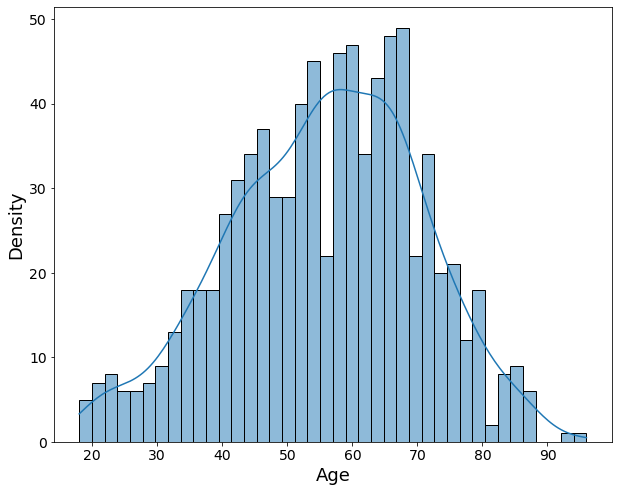

In [13]:
# Continuous density plot
fig_missing, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram
_ = sns.histplot(x="age", kde=True, data=df_mam, ax=axes, bins=40);
_ = axes.set(xlabel="Age", ylabel='Density');
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);

Data seems fairly reasonable, no outliers. We will continue with analysis for now, and do a more in-depth EDA in a
later notebook.



In [14]:
df_mam['score'].value_counts()

4     468
5     316
3      24
6       9
2       7
0       5
55      1
Name: score, dtype: int64

We observe that one value was probably incorrectly captured (as this score does not exist), we map the value of 55 to
 5. 

In [15]:
idx = df_mam[df_mam['score'] == 55].index
df_mam.loc[idx, 'score'] = 5

In [16]:
df_mam['score'].value_counts()

4    468
5    317
3     24
6      9
2      7
0      5
Name: score, dtype: int64

Data is not sorted and does not have a meaningful index for baseline. We sort data and create new index.

In [17]:
df_mam = df_mam.sort_values(['age', 'score', 'density', 'malignanttrue'], ascending=[True, True, True, True])
df_mam = df_mam.reset_index(drop=True)

Next we consider the categorical variables.

We first look at the distribution of the response.

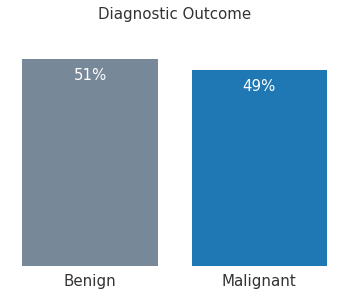

In [18]:
_ = plt.figure()

# Plot outcome counts.a
outcome_counts = df_mam_orig['malignanttrue'].value_counts(normalize = True)
legend_labels = ['Benign', 'Malignant']

# change the background bar colors to be light grey
bars = plt.bar(outcome_counts.index, outcome_counts.values, align='center', linewidth=0,
               color='lightslategrey')
# make one bar, the survived bar, a contrasting color
bars[1].set_color('#1F77B4')

# soften all labels by turning grey
_ = plt.xticks(outcome_counts.index, legend_labels, fontsize=15, alpha=0.8)
_ = plt.title('Diagnostic Outcome', fontsize=15, pad=30, alpha=0.8)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Remove the frame - my method
ax = plt.gca()
ax.set_frame_on(False)

# Remove the frame of the chart - instructor's method
#for spine in plt.gca().spines.values():
#    spine.set_visible(False)

# direct label each bar with Y axis values
for bar in bars:
    _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                       str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                       fontsize=15)

plt.show()

In [19]:
df_mam['malignanttrue'].value_counts()

0    427
1    403
Name: malignanttrue, dtype: int64

We observe that the classes are well balanced. No need for boosting.

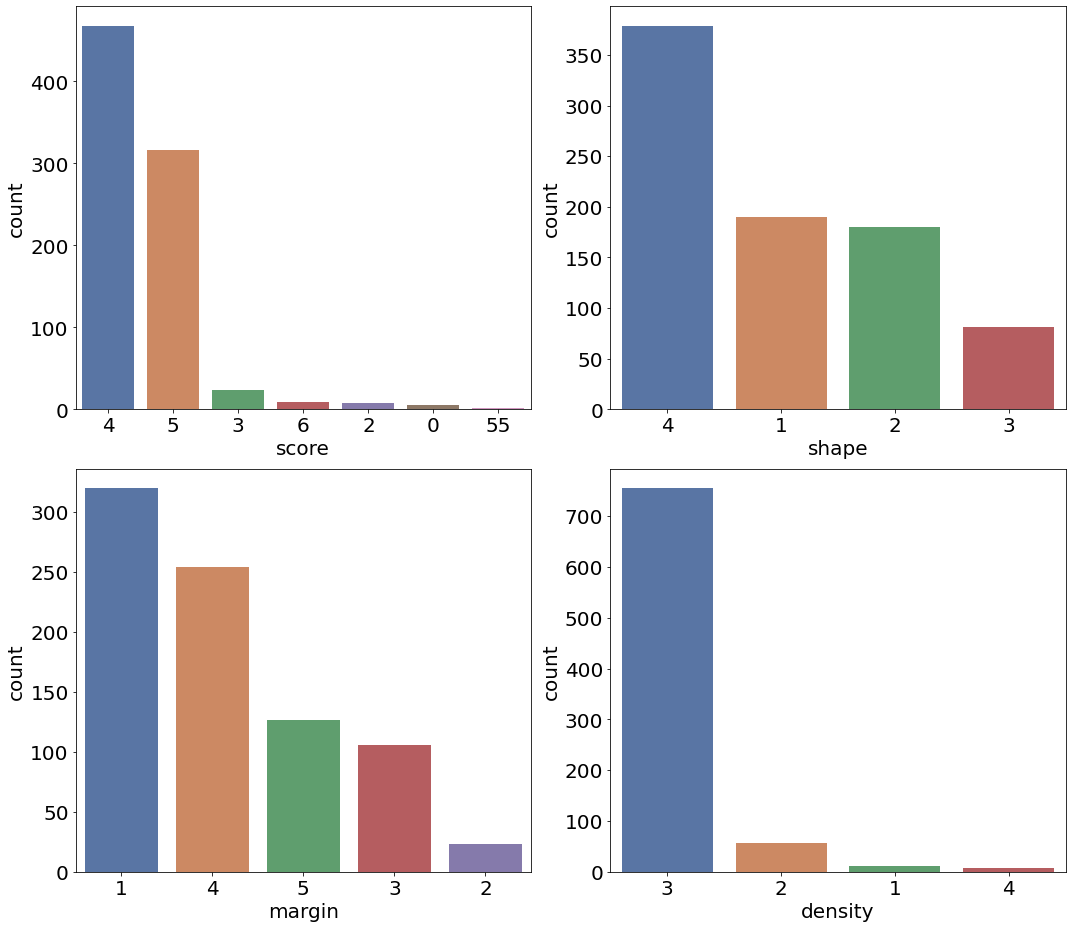

In [20]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(2, 2, figsize=(15, 13));
for variable, subplot in zip(quantitative_cols, ax.flatten()):
    subplot.xaxis.label.set_size(20)
    subplot.yaxis.label.set_size(20)
    subplot.tick_params('y', labelsize = 20);
    subplot.tick_params('x', labelsize = 20);
    cp = sns.countplot(x=df_mam_orig[variable], ax=subplot, palette='deep', order =
    df_mam_orig[variable].value_counts().index);
plt.tight_layout()

There is good variation in all the categorical variables. We will perform a more in depth analysis later.

<div class="alert alert-block alert-info">
<b>Build Models</b>
</div>

We now build a baseline model followed by setting up a Voting Classifier.

In [21]:
X = df_mam.iloc[:, np.r_[1:11]]
y = df_mam.iloc[:, 0]

In [22]:
y = np.ravel(y)

# Split the data into the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We scale the data next.

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [24]:
col_names = list(X.columns.values)
X_train = pd.DataFrame(X_train, columns=col_names)

The scaled dataset looks as follows:

In [25]:
X_train.head()


,score,age,shape_2,shape_3,shape_4,margin_2,margin_3,margin_4,margin_5,density
0,0.991644,0.085514,-0.506523,-0.326744,1.098032,-0.172631,-0.364649,1.490905,-0.432461,0.256124
1,0.991644,-0.680308,-0.506523,-0.326744,1.098032,-0.172631,2.742362,-0.670734,-0.432461,0.256124
2,-0.449484,-1.237269,1.974244,-0.326744,-0.910720,-0.172631,-0.364649,-0.670734,-0.432461,-2.640410
3,0.991644,0.572855,-0.506523,-0.326744,1.098032,-0.172631,-0.364649,1.490905,-0.432461,0.256124
4,-0.449484,-0.332207,-0.506523,-0.326744,1.098032,-0.172631,2.742362,-0.670734,-0.432461,0.256124


Next, fit a two-layer MLP classifier with 5 nodes on each layer.

In [26]:
reg = MLPClassifier(max_iter=1000, hidden_layer_sizes=(5,5), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
accuracy_score(y_pred,y_test)

0.8557692307692307

We can see that there is a strong signal in the data. A score of 86% for an unoptimised MLP is very good. The model
is probably overfit, so we will do some high-level tests on number of nodes per layer. We will do a more advanced
hyper-parameter optimisation exercise using GridSearch in a later Notebook.

In [27]:
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(3,6) for j in range(3,6)]:

    reg = MLPClassifier(max_iter=10000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

Nodes |Validation
      | score
(3, 3) : 0.80547
(3, 4) : 0.81672
(3, 5) : 0.81190
(4, 3) : 0.82154
(4, 4) : 0.82315
(4, 5) : 0.81350
(5, 3) : 0.82797
(5, 4) : 0.81029
(5, 5) : 0.82154


In [28]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))  
optimal_hidden_layer_size = [name for name, score in validation_scores.items() 
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )

The highest validation score is: 0.8280
This corresponds to nodes (5, 3)


As expected the model was overfit. The reduced number of nodes is an indication of better fit on the validation data
by a less complex model.

In [29]:
clf_best = MLPClassifier(max_iter=1000, hidden_layer_sizes=optimal_hidden_layer_size, random_state=1)
clf_best.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(5, 3), max_iter=1000, random_state=1)

In [30]:
y_pred = clf_best.predict(X_test)
accuracy_score(y_pred,y_test)

0.8557692307692307

The accuracy score on the optimised model slightly reduced. This is not a bad thing as the dataset is small and a
more robust model is preferred over a more accurate overfit model.

We will now fit a voting classifier to compare our MLP results with a few other models. Just to compare to a few
other models.

In [52]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)
model_name = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'Final']

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

accuracy = []
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    accuracy.append(acc_score)
    print(clf.__class__.__name__, acc_score)

LogisticRegression 0.8509615384615384
RandomForestClassifier 0.8076923076923077
SVC 0.8557692307692307
VotingClassifier 0.8605769230769231


In [54]:
# Call the prediction function
y_pred = svm_clf.predict(X_test)

# Display the confusion matrix to check result (accuracy and so on)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[88 21]
 [ 9 90]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       109
           1       0.81      0.91      0.86        99

    accuracy                           0.86       208
   macro avg       0.86      0.86      0.86       208
weighted avg       0.86      0.86      0.86       208



In [55]:
# Call the prediction function
y_pred = log_clf.predict(X_test)

# Display the confusion matrix to check result (accuracy and so on)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[89 20]
 [11 88]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       109
           1       0.81      0.89      0.85        99

    accuracy                           0.85       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.85      0.85      0.85       208



In [56]:
# Call the prediction function
y_pred = rnd_clf.predict(X_test)

# Display the confusion matrix to check result (accuracy and so on)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[88 21]
 [19 80]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       109
           1       0.79      0.81      0.80        99

    accuracy                           0.81       208
   macro avg       0.81      0.81      0.81       208
weighted avg       0.81      0.81      0.81       208



Text(0.5, 1.0, 'Voting Classifier Results')

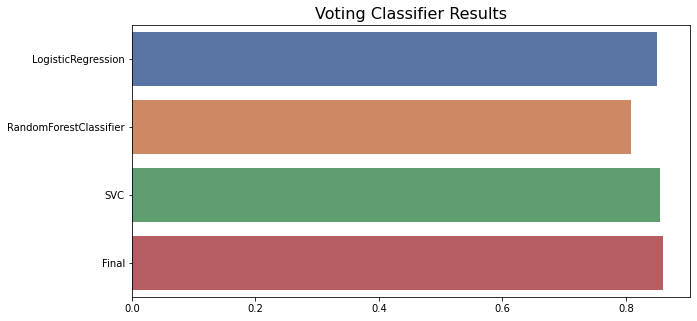

In [32]:
plt.figure(figsize = (10,5))
sns.barplot(x = accuracy, y = model_name, palette='deep')
plt.title("Voting Classifier Results", fontsize=16)

The Support Vector Machine narrowly won over the Logistic Regression. There seems to be a fairly linear
relationship between features and responses. Our future EDA will probably confirm this.

Voting Classifiers enable an easy way of quickly comparing various models. A very useful tool indeed!

We now draw the response curves, based on our optimised MLP results.

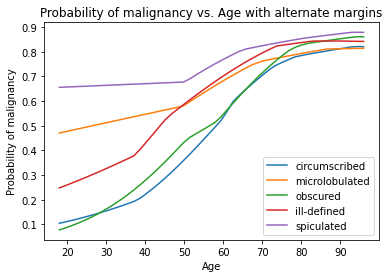

In [33]:
X_design = X.copy()
X_design_vec = pd.DataFrame(X_design.mean()).transpose()

margin= range(4,9)

for i in margin:
    X_design_vec.loc[0,["margin_2","margin_3","margin_4","margin_5"]]=[0,0,0,0]
    if i!=4:
        X_design_vec.iloc[0,i]=1

    min_resultant = min(X.loc[:,"age"])
    max_resultant = max(X.loc[:,"age"])
    seq = np.linspace(start=min_resultant,stop=max_resultant,num=50)

    to_predict = []
    for result in seq:
        X_design_vec.loc[0,"age"] = result
        to_predict.append(X_design_vec.copy())

    to_predict = pd.concat(to_predict)

    to_predict = scaler.transform(to_predict)
    predictions = clf_best.predict_proba(to_predict)
    plt.plot(seq,predictions[:,1])
plt.xlabel("Age")
plt.ylabel("Probability of malignancy")
plt.title("Probability of malignancy vs. Age with alternate margins")
plt.legend(labels=["circumscribed","microlobulated","obscured","ill-defined","spiculated"],loc='best')
plt.show()


The curves clearly indicate an increase in probability of cancer as age increase, which makes sense. The model
therefore captures this signal correctly, which is a good confirmation. Interesting to see the difference in
relationship with the response for the different margin variables. The margins all converge to similar probabilities
for older ages. The spiculated margin is associated more strongly with cancer in younger patients.
The circumscribed and microlobulated margins have a much higher probability for older ages than any of the others,
even though it is the lowest for lower ages. Clearly strong age related predictors.

This analysis showed some interesting results based on a very few variables. More EDA is certain to show more
interesting patterns in the data.

On to the next Notebook!

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

0.861244019138756

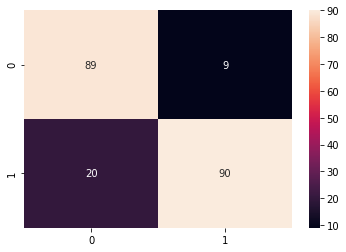

In [35]:
sns.heatmap(confusion_matrix(clf.predict(X_test), y_test),annot=True)
f1_score(clf.predict(X_test), y_test)